In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize, minimize_scalar

In [2]:
with open('/home/quantum/Documents/iltpe/SiO2Damon1973.txt', 'r') as f:
    data = f.readlines()
data = [d.split('\t') for d in data]
data = pd.DataFrame(data[1:], columns=['T', 'k'])
data['k'] = data['k'].str.replace('\n', '')
for c in data.columns:
    data[c] = data[c].astype('float')

In [3]:
data['T_log'] = np.log(data['T'])
data['k_log'] = np.log(data['k'])

In [4]:
z = np.polyfit(data['T_log'], data['k_log'], 6)
p = np.poly1d(z)
xp = np.linspace(0, 5, 100)
ap_df = pd.DataFrame({'x':xp})

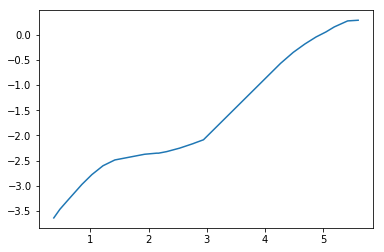

In [34]:
plt.plot(data['T_log'], data['k_log'])

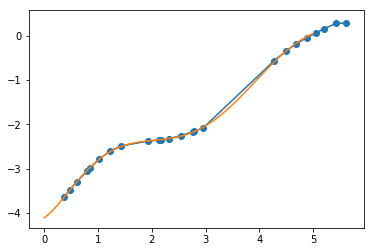

In [5]:
plt.plot(data['T_log'], data['k_log'])
plt.scatter(data['T_log'], data['k_log'])
plt.plot(xp, p(xp))

In [6]:
ap_df['y'] = [p(x) for x in xp]

In [7]:
p1 = np.polyder(p, m=1)
p2 = np.polyder(p, m=2)
p3 = np.polyder(p, m=3)
roots = np.roots(p3)

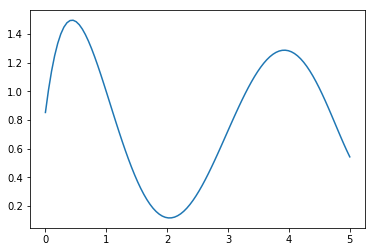

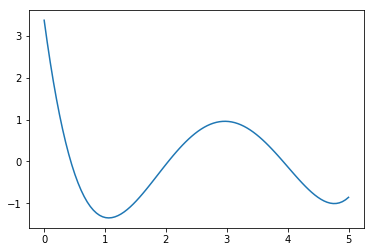

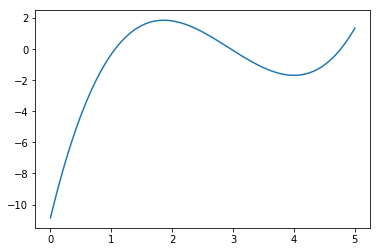

In [8]:
ap_df['yd1'] = [p1(x) for x in xp]
ap_df['yd2'] = [p2(x) for x in xp]
ap_df['yd3'] = [p3(x) for x in xp]

plt.figure()
for f in ('yd1', 'yd2', 'yd3'):
    plt.plot(ap_df['x'], ap_df[f])
    plt.show()

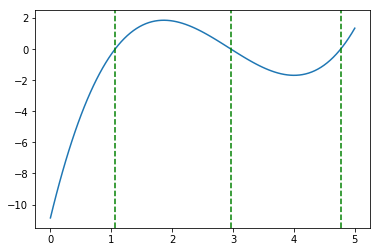

In [9]:
plt.plot(ap_df['x'], ap_df['yd3'])
for r in roots:
    plt.axvline(x=r, color='g', linestyle='--')

In [10]:
plateau = sorted(roots)[:2]
data_pl = ap_df[(ap_df['x']>plateau[0]) & (ap_df['x']<plateau[1])]

In [11]:
z_l = np.polyfit(data_pl['x'], data_pl['y'], 1)
p_l = np.poly1d(z_l)

xp_l = np.linspace(0, 4, 100)
yp_l = [p_l(x) for x  in xp_l]

In [13]:
b = list(np.linspace(data_pl['y'].min(), data_pl['y'].max(), 100))

In [14]:
def mse(w1, y):
    return np.mean((w1 - y)**2)

def f(w1):
    loss = sum([mse(w1, y) for y in data_pl['y']])
    return loss
res = minimize_scalar(f)

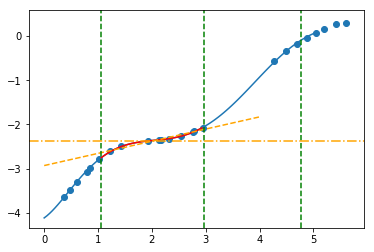

In [15]:
plt.plot(ap_df['x'], ap_df['y'])
plt.scatter(data['T_log'], data['k_log'])
plt.plot(data_pl['x'], data_pl['y'], color='r')
plt.plot(xp_l, yp_l,  color='orange', linestyle='--')
for r in roots:
    plt.axvline(x=r, color='g', linestyle='--')
plt.axhline(y=res.x, color='orange', linestyle='-.')

In [16]:
data_pl['ae'] = [res.x - y for y in data_pl['y']]

/home/quantum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([3., 2., 4., 7., 9., 4., 3., 2., 2., 2.]),
 array([-0.30160039, -0.23449977, -0.16739916, -0.10029855, -0.03319793,
         0.03390268,  0.10100329,  0.16810391,  0.23520452,  0.30230514,
         0.36940575]),
 <a list of 10 Patch objects>)

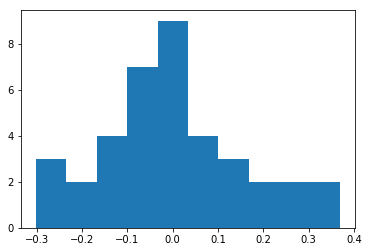

In [17]:
plt.hist(data_pl['ae'])

In [18]:
var = np.var(data_pl['ae'])

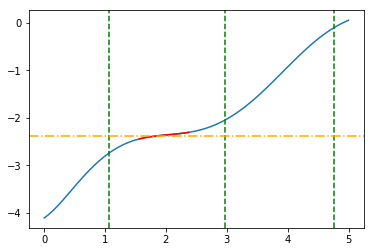

In [19]:
data_pl_f = data_pl[data_pl['ae'].abs()<3*var]
plt.plot(ap_df['x'], ap_df['y'])
#plt.scatter(data['T_log'], data['k_log'])
plt.plot(data_pl_f['x'], data_pl_f['y'], color='r')
#plt.plot(xp_l, yp_l,  color='orange', linestyle='--')
for r in roots:
    plt.axvline(x=r, color='g', linestyle='--')
plt.axhline(y=res.x, color='orange', linestyle='-.')

In [20]:
def k1(T, sigma, betta, k_pl):
    return k_pl * (betta * T**(2-sigma))/(k_pl + (betta * T**(2-sigma)))

In [21]:
def k1_inv(T, sigma, betta, k_pl):
    return 1/(betta*T**(2-sigma))+1/k_pl

In [22]:
def k2(T, k0, E):
    return k0*np.exp(-E/T)

In [23]:
k_pl = np.exp(data_pl_f['y'].mean())
x = ap_df[ap_df['x']<data_pl_f['x'].min()]['x']
T = np.exp(x)
y = ap_df[ap_df['x']<data_pl_f['x'].min()]['y']
k = np.exp(y)

In [24]:
def loss_k1(params):
    sigma = params['sigma']  
    betta = params['betta']
    k_fit = [k1(np.exp(t), sigma, betta, k_pl) for t in T]
    return np.mean((k_fit - k)**2)

In [25]:
loss_k1({'sigma':0.001, 'betta':0.2})

0.002409081827134433

In [26]:
# init_g = [0.01, 0.01]
# res = minimize(loss_k1, init_g, method='Nelder-Mead', tol=1e-10)

In [40]:
# LEan to the thrmal resistance

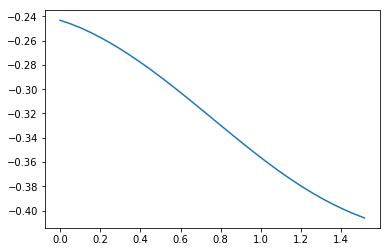

In [39]:
plt.plot(x, [1/k_ for k_ in y])
#plt.plot(T, k1_fitted)

100%|██████████| 5000/5000 [02:33<00:00, 32.53it/s, best loss: 6.0605630954255883e-05]
{'betta': 0.02076345517235533, 'sigma': 1.2500580620963342}


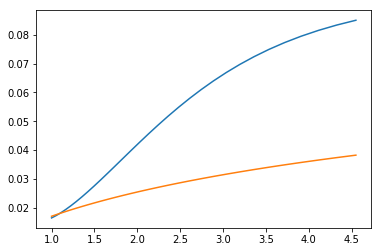

In [27]:
from hyperopt import fmin, tpe, hp
space = {'sigma': hp.uniform('sigma', 0, 2),
        'betta': hp.uniform('betta', -10, 10)}

best = fmin(fn=loss_k1,
    space=space,
    algo=tpe.suggest,
    max_evals=5000)
print(best)

sigma = best["sigma"]
betta = best["betta"]
k1_fitted = k1(T, sigma, betta, k_pl)
plt.plot(T, k)
plt.plot(T, k1_fitted)

In [28]:
z = np.polyfit(data['T_log'], data['k_log'], 6)
p = np.poly1d(z)
xp = np.linspace(0, 5, 100)
ap_df = pd.DataFrame({'x':xp})